### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc.

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

IMG_SHAPE = (36, 36, 3)

In [4]:
from lfw_dataset import fetch_lfw_dataset

data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

(36, 36, 3)

### Define Generator and Discriminator

In [7]:
CODE_SIZE = 256

# GENERATOR

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2D(3, kernel_size=3,activation='tanh'))

# DISCRIMINATOR

discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))
discriminator.add(L.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(L.LeakyReLU())
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(L.LeakyReLU())
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [8]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [9]:
disc_optimizer = tf.optimizers.Adam(learning_rate=0.0002)
gen_optimizer = tf.optimizers.Adam(learning_rate=0.0002)

In [5]:
import datetime
%load_ext tensorboard

In [12]:
summary_writer = tf.summary.create_file_writer('logs')
global_step = tf.Variable(0, dtype=tf.int64)

1/1 [==============================] - 0s 19ms/step


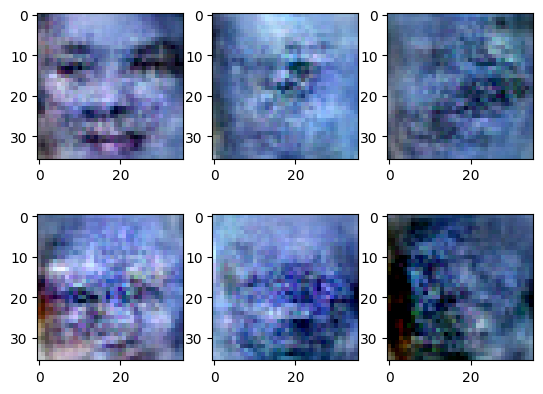

32/32 [==============================] - 0s 2ms/step


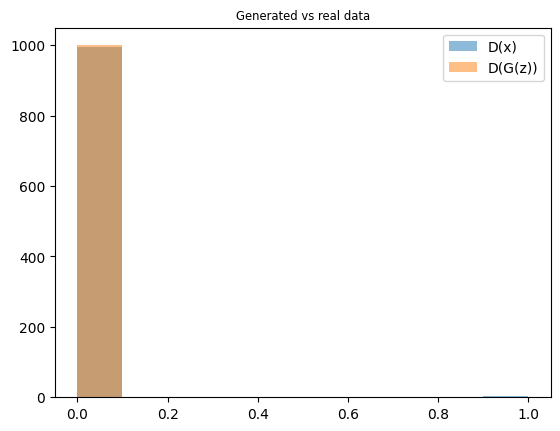

 29%|██▉       | 28835/100000 [1:47:47<4:09:23,  4.76it/s]

In [ ]:
from IPython import display
from tqdm import tqdm

@tf.function
def disc_loss():
    # Discriminator loss
    logp_real = discriminator(real_data)
    generated_data = generator(noise)
    logp_gen = discriminator(generated_data)
    d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
    d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)
    return d_loss


@tf.function
def gen_loss():
    # Generator loss
    logp_real = discriminator(real_data)
    generated_data = generator(noise)
    logp_gen = discriminator(generated_data)
    g_loss = -tf.reduce_mean(logp_gen[:,1])
    return g_loss



for epoch in tqdm(range(100000)):
    real_data = sample_data_batch(50)
    noise = sample_noise_batch(50)


    ########################
    #discriminator training#
    ########################
    for i in range(5):
        disc_optimizer.minimize(disc_loss, var_list=discriminator.trainable_weights)

    ########################
    ###generator training###
    ########################
    gen_optimizer.minimize(gen_loss, var_list=generator.trainable_weights)


    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        
    with summary_writer.as_default():
        tf.summary.scalar('Discriminator Loss', disc_loss(), step=global_step)
        tf.summary.scalar('Generator Loss', gen_loss(), step=global_step)
    global_step.assign_add(1)

# Close the summary writer after training completes
summary_writer.close()

In [ ]:
# Save models
discriminator.save_weights("discriminator.ckpt")
generator.save_weights("generator.ckpt")

In [3]:
# Visualize with tensorboard
tensorboard --logdir logs

SyntaxError: invalid syntax (4154384377.py, line 2)

# Load model and plot sample

In [9]:
# Load models (*Note* You must define the discriminator and generator above.)
discriminator.load_weights("discriminator/discriminator.ckpt")
generator.load_weights("generator/generator.ckpt")

1/1 [==============================] - 0s 16ms/step


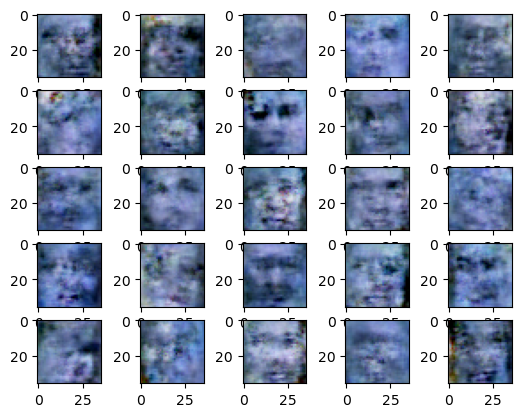

In [58]:
sample_images(5, 5)